In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn import svm
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from skimage import data
from sklearn import metrics
from tqdm.notebook import tqdm

## Read Data

In [2]:
%run ../Preprocessing/Read_Data.ipynb

100%|██████████| 286/286 [00:23<00:00, 12.24it/s]


In [14]:
# Variables:
get_sum__ = True
in_one__ = False

## Extract Features

In [4]:
def get_glcm_feature(gray_scale_img, name, get_sum=False):
    GLCM = greycomatrix(gray_scale_img, distances = [1], angles = [0, np.pi/4, np.pi/2, np.pi*3/4 ], levels=256, normed=True)
    # P[i,j,d,theta] is the number of times that grey-level j occurs at a distance d and at an angle theta from grey-level i.
    if name=='entropy':
        entropy = []
        for i in range(GLCM.shape[3]):
            entropy.append(shannon_entropy(GLCM[:,:,:,i], base=np.e))
        if get_sum:
            return np.sum(np.abs(entropy))
        return np.array(entropy)
    if get_sum:
        return np.sum(np.abs(greycoprops(GLCM, prop=name)))
    return np.array(greycoprops(GLCM, prop=name))

In [5]:
# Gets the GLCM properties in the following order: Contrast, Correlation, Homogeneity, Entropy & Energy
# It gets them at four directions: 0, 45, 90 & 135
# Therefore, it produces a feature with dimension 20 (5 properties * 4 directions)
def get_all_GLCM_features(x, get_sum=False):
    contrast = None
    correlation = None
    homogeneity = None
    energy = None
    entropy = None
    if get_sum:
        contrast =  np.array([get_glcm_feature(img, 'contrast', get_sum=True) for img in tqdm(x)])
        correlation = np.array([get_glcm_feature(img, 'correlation', get_sum=True) for img in tqdm(x)])
        homogeneity = np.array([get_glcm_feature(img, 'homogeneity', get_sum=True) for img in tqdm(x)])
        energy = np.array([get_glcm_feature(img, 'energy', get_sum=True) for img in tqdm(x)])
        entropy = np.array([get_glcm_feature(img, 'entropy', get_sum=True) for img in tqdm(x)])
    else:
        contrast = np.array([np.array(get_glcm_feature(img, 'contrast')[0]) for img in tqdm(x)])
        correlation = np.array([np.array(get_glcm_feature(img, 'correlation')[0]) for img in tqdm(x)])
        homogeneity = np.array([np.array(get_glcm_feature(img, 'homogeneity')[0]) for img in tqdm(x)])
        energy = np.array([np.array(get_glcm_feature(img, 'energy')[0]) for img in tqdm(x)])
        entropy = np.array([get_glcm_feature(img, 'entropy') for img in tqdm(x)])
    return contrast, correlation, homogeneity, energy, entropy

In [6]:
def plot_2_features(feature1, feature2, y_train, label1='feature 1', label2='feature 2', in_one_plot=False, k=1):
  # Generate scatter plot for training data 
  x_train = np.vstack((feature1 ,feature2)).T
  x_train_male = x_train[y_train == 0]
  x_train_female = x_train[y_train == 1]
  plt.scatter(x_train_male[:,0], x_train_male[:,1], color='blue', s=4)
  plt.scatter(x_train_female[:,0], x_train_female[:,1], color='red', s=4)
  if in_one_plot:
    ax = plt.subplot(20,10,k)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
  else:
    plt.title(label1+ " Vs. " + label2)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.show()

In [7]:
def show_all_GLCM_2D_graphs(contrast,correlation,homogeneity,energy,entropy,y_train, get_sum=False, in_one=False):
  angle_label = ['0', 'np.pi/4', 'np.pi/2', 'np.pi*3/4']
  property_label = ['contrast', 'correlation', 'homogeneity', 'energy', 'entropy']
  if in_one:
    plt.figure(figsize=(16, 12), dpi=160)
  k = 1
  if get_sum:
    plot_2_features(contrast,correlation, y_train, 'GLCM Contrast', 'GLCM Correlation',in_one,k)
    k+=1
    plot_2_features(contrast,homogeneity, y_train, 'GLCM Contrast', 'GLCM Homogeneity',in_one,k)
    k+=1
    plot_2_features(contrast,energy, y_train, 'GLCM Contrast', 'GLCM Energy',in_one,k)
    k+=1
    plot_2_features(contrast,entropy, y_train, 'GLCM Contrast', 'GLCM Entropy',in_one,k)
    k+=1
    plot_2_features(correlation,homogeneity, y_train, 'GLCM Correlation', 'GLCM Homogeneity',in_one,k)
    k+=1
    plot_2_features(correlation,energy, y_train, 'GLCM Correlation', 'GLCM Energy',in_one,k)
    k+=1
    plot_2_features(correlation,entropy, y_train, 'GLCM Correlation', 'GLCM Entropy',in_one,k)
    k+=1
    plot_2_features(homogeneity,energy, y_train, 'GLCM Homogeneity', 'GLCM Energy',in_one,k)
    k+=1
    plot_2_features(homogeneity,entropy, y_train, 'GLCM Homogeneity', 'GLCM Entropy',in_one,k)
    k+=1
    plot_2_features(energy,entropy, y_train, 'GLCM Energy', 'GLCM Entropy',in_one,k)
  else:
    for i in range(contrast.shape[1]):
      for j in range(correlation.shape[1]):
        if(i<j):
          plot_2_features(contrast[:,i],contrast[:,j], y_train, 'GLCM Contrast at '+angle_label[i], 'GLCM Contrast at '+angle_label[j],in_one,k)
          k+=1
        plot_2_features(contrast[:,i],correlation[:,j], y_train, 'GLCM Contrast at '+angle_label[i], 'GLCM Correlation at '+angle_label[j],in_one,k)
        k+=1
        plot_2_features(contrast[:,i],homogeneity[:,j], y_train, 'GLCM Contrast at '+angle_label[i], 'GLCM Homogeneity at '+angle_label[j],in_one,k)
        k+=1
        plot_2_features(contrast[:,i],energy[:,j], y_train, 'GLCM Contrast at '+angle_label[i], 'GLCM Energy at '+angle_label[j],in_one,k)
        k+=1
        plot_2_features(contrast[:,i],entropy[:,j], y_train, 'GLCM Contrast at '+angle_label[i], 'GLCM Entropy at '+angle_label[j],in_one,k)
        k+=1
    for i in range(correlation.shape[1]):
      for j in range(homogeneity.shape[1]):
        if(i<j):
          plot_2_features(correlation[:,i],correlation[:,j], y_train, 'GLCM Correlation at '+angle_label[i], 'GLCM Correlation at '+angle_label[j],in_one,k)
          k+=1
        plot_2_features(correlation[:,i],homogeneity[:,j], y_train, 'GLCM Correlation at '+angle_label[i], 'GLCM Homogeneity at '+angle_label[j],in_one,k)
        k+=1
        plot_2_features(correlation[:,i],energy[:,j], y_train, 'GLCM Correlation at '+angle_label[i], 'GLCM Energy at '+angle_label[j],in_one,k)
        k+=1
        plot_2_features(correlation[:,i],entropy[:,j], y_train, 'GLCM Correlation at '+angle_label[i], 'GLCM Entropy at '+angle_label[j],in_one,k)
        k+=1
    for i in range(homogeneity.shape[1]):
      for j in range(energy.shape[1]):
        if(i<j):
          plot_2_features(homogeneity[:,i],homogeneity[:,j], y_train, 'GLCM Homogeneity at '+angle_label[i], 'GLCM Homogeneity at '+angle_label[j],in_one,k)
          k+=1
        plot_2_features(homogeneity[:,i],energy[:,j], y_train, 'GLCM Homogeneity at '+angle_label[i], 'GLCM Energy at '+angle_label[j],in_one,k)
        k+=1
        plot_2_features(homogeneity[:,i],entropy[:,j], y_train, 'GLCM Homogeneity at '+angle_label[i], 'GLCM Entropy at '+angle_label[j],in_one,k)
        k+=1
    for i in range(energy.shape[1]):
      for j in range(entropy.shape[1]):
        if(i<j):
          plot_2_features(energy[:,i],energy[:,j], y_train, 'GLCM Energy at '+angle_label[i], 'GLCM Energy at '+angle_label[j],in_one,k)
          k+=1
        plot_2_features(energy[:,i],entropy[:,j], y_train, 'GLCM Energy at '+angle_label[i], 'GLCM Entropy at '+angle_label[j],in_one,k)
        k+=1
    for i in range(entropy.shape[1]):
      for j in range(entropy.shape[1]):
        if(i<j):
          plot_2_features(entropy[:,i],entropy[:,j], y_train, 'GLCM Entropy at '+angle_label[i], 'GLCM Entropy at '+angle_label[j],in_one,k)
          k+=1

Running the code & Graphing

In [8]:
contrast, correlation, homogeneity, energy, entropy = get_all_GLCM_features(x_train,get_sum=get_sum__)
contrastt, correlationt, homogeneityt, energyt, entropyt = get_all_GLCM_features(x_test,get_sum=get_sum__)

100%|██████████| 91/91 [00:04<00:00, 21.48it/s]


In [9]:
# show_all_GLCM_2D_graphs(contrast,correlation,homogeneity,energy,entropy, y_train, get_sum=False, in_one=True)

In [15]:
if get_sum__:
    x_train = np.stack((contrast, correlation, homogeneity, energy, entropy)).T
    x_test = np.stack((contrastt, correlationt, homogeneityt, energyt, entropyt)).T
else:
    x_train = np.hstack((contrast, correlation, homogeneity, energy, entropy))
    x_test = np.hstack((contrastt, correlationt, homogeneityt, energyt, entropyt))
print(x_train.shape)

(836, 5)


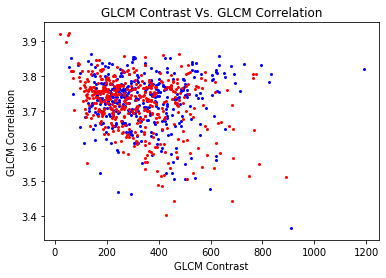

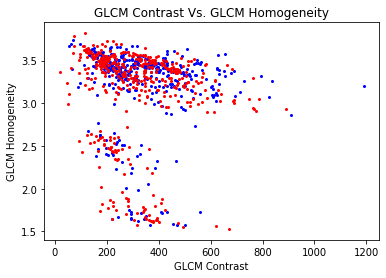

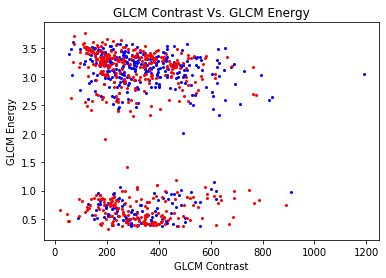

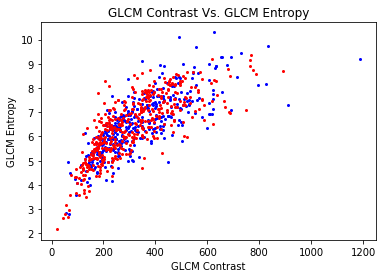

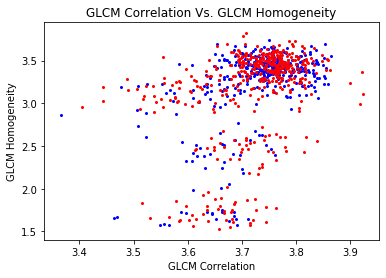

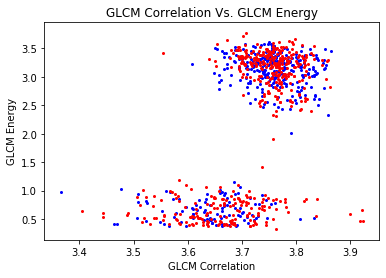

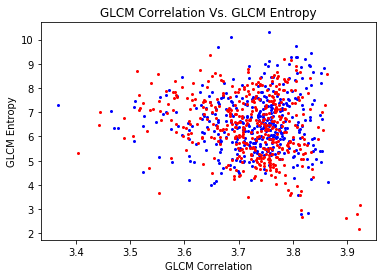

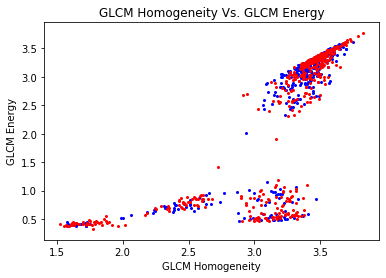

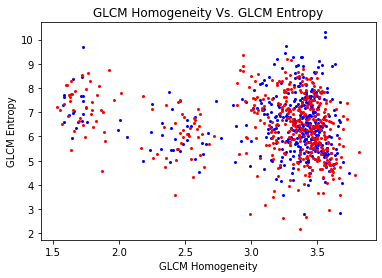

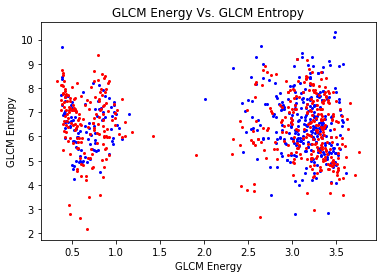

In [16]:
show_all_GLCM_2D_graphs(contrast,correlation,homogeneity,energy,entropy, y_train, get_sum=get_sum__, in_one=in_one__)